# Supernova Cosmology
This notebook shows how to use data from the supernova cosmology project to constrain the cosmological parameters. The key tool used here to realize MCMC is `emcee`.

In [189]:
#----------------------------------------------------------------------
# Import some nessesary packages.
import numpy as np
from matplotlib import pyplot as plt
from astroML.cosmology import Cosmology
#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=13, usetex=True)

## First, we test our code using fake data generated by astroML.

In [190]:
# Generate Fake supernova data
from astroML.datasets import generate_mu_z
#------------------------------------------------------------
# Generate the data
z_sample, mu_sample, dmu = generate_mu_z(100, z0=0.3,
                                         dmu_0=0.05, dmu_1=0.004,
                                         random_state=1)

In [191]:
#------------------------------------------------------------
# define a log likelihood in terms of the parameters theta = [omegaM, omegaL]

def model(theta, x):
    cosmo = Cosmology(omegaM=theta[0], omegaL=theta[1])
    xdim = len(x)
    return np.array([cosmo.mu(z_sample[i]) for i in range(xdim)])

def lnLikelihood(theta, x, y, yerr):
    a, b, lnf = theta
    model_value = model(theta, x)
    if np.any(np.isnan(model_value)):
        return -np.inf
    else:
        inv = 1/(yerr**2 + (model_value**2 * np.exp(2*lnf)))
        inv = inv/(2*np.pi)
        return -0.5*np.sum(inv*(model_value-y)**2)+0.5*np.sum(np.log(inv))

def lnPrior(theta):
    omegaM, omegaL, lnf = theta
    if 0<omegaM<2.5 and -1<omegaL<3 and lnf<1:
        return 0.0
    return -np.inf

def lnProb(theta, x, y, yerr):
    prior = lnPrior(theta)
    likelihood = lnLikelihood(theta, x, y, yerr)
    if ~np.isfinite(prior) or ~np.isfinite(likelihood):
        return -np.inf
    return prior + likelihood

In [192]:
#------------------------------------------------------------
# Start MCMC: 100 walkers, 500 steps for each.
# This could take quite a while!!! (maybe 10 mins)
import emcee
sampler.reset()
ndim, nwalkers = 3, 100
pos = emcee.utils.sample_ball([0.3, 0.7, -9], [1e-1 for i in range(ndim)], size=nwalkers)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnProb, args=(z_sample, mu_sample, dmu))
nsteps = 500
pos, prob, state = sampler.run_mcmc(pos, nsteps)

/Users/higroup/anaconda3/lib/python3.6/site-packages/astroML/cosmology.py:78: RuntimeWarning: invalid value encountered in log10
  return 5. * np.log10(self.Dl(z) * 1E6) - 5.
/Users/higroup/anaconda3/lib/python3.6/site-packages/astroML/cosmology.py:43: RuntimeWarning: invalid value encountered in sqrt
  + self.omegaL)
/Users/higroup/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/higroup/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/Users/higroup/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in multiply
  from ipykernel import kernelapp as app


In [46]:
#------------------------------------------------------------
# Check Quality
samples = sampler.flatchain
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
# The mean acceptance fraction will between 0.25 and 0.65 if everything goes well.

Mean acceptance fraction: 0.600


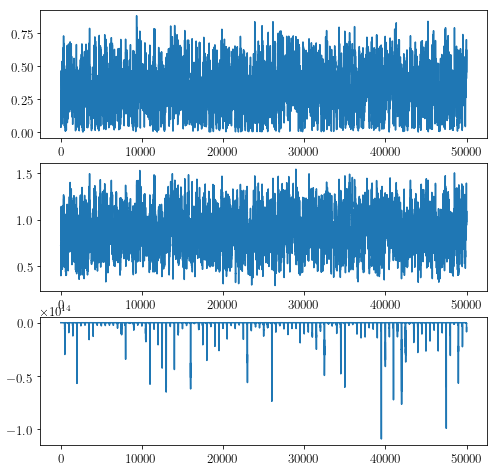

In [186]:
#------------------------------------------------------------
# The evolution of parameters
fig = plt.figure(figsize=(8,8))
ax1 = plt.subplot2grid((3,1),(0,0))
plt.plot(samples[:,0])
ax2 = plt.subplot2grid((3,1),(1,0))
plt.plot(samples[:,1])
ax3 = plt.subplot2grid((3,1),(2,0))
plt.plot(samples[:,2])
plt.show()

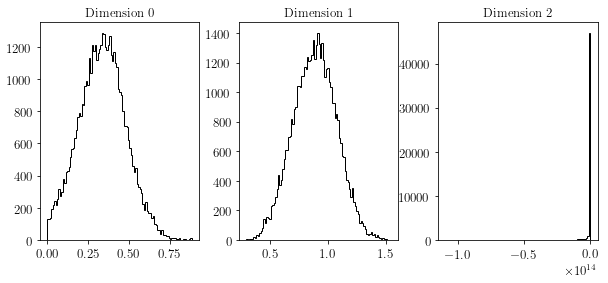

In [185]:
#------------------------------------------------------------
# 1d Histogram of parameters
fig, ax = plt.subplots(1, 3, sharey=False, figsize=(10,4))
for i in range(ndim):
    ax[i].hist(sampler.flatchain[100:,i], 100, color="k", histtype="step")
    ax[i].set_title("Dimension {0:d}".format(i))
plt.subplots_adjust(wspace=0.25)
plt.show()

In [139]:
#------------------------------------------------------------
# Print the values of parameters after MCMC. 
# Note that the second value in the tuple is the upper deviation, while the third is the lower deviation. 

OmegaM_mcmc, OmegaL_mcmc, lnf_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print(OmegaM_mcmc, OmegaL_mcmc, lnf_mcmc)

Text(0.1,1.4,'$\\Omega_\\Lambda=0.88^{+0.18}_{-0.19}$')

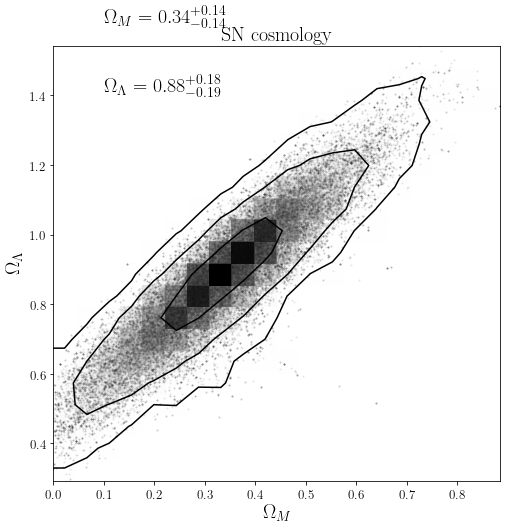

In [187]:
#------------------------------------------------------------
# 2d Histogram of two parameters. Contours correspond to 1sigma, 2sigma and 3sigma.

fig, ax = plt.subplots(figsize=(8,8))
corner.hist2d(samples.T[0], samples.T[1], ax=ax, 
              levels = 1.0 - np.exp(-0.5 * np.array([1, 2, 3]) ** 2), no_fill_contours=True)
ax.set_title('SN cosmology', fontsize=20)
ax.set_xlabel(r'$\Omega_M$', fontsize=20)
ax.set_ylabel(r'$\Omega_\Lambda$', fontsize=20)
ax.text(0.10, 1.6, r'$\Omega_M='+str(round(OmegaM_mcmc[0],2))
        +'^{+'+str(round(OmegaM_mcmc[1],2))
        +'}_{-'+str(round(OmegaM_mcmc[2],2))+'}$', fontsize=20)
ax.text(0.10, 1.4, r'$\Omega_\Lambda='+str('{:.2f}'.format(round(OmegaL_mcmc[0], 2)))
        +'^{+'+str(round(OmegaL_mcmc[1],2))
        +'}_{-'+str(round(OmegaL_mcmc[2],2))+'}$', fontsize=20)

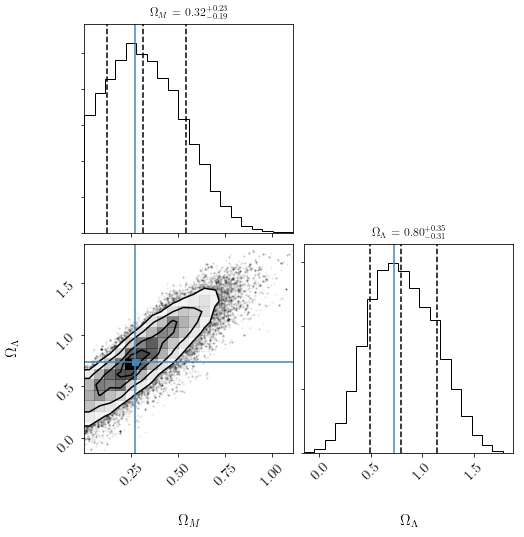

In [138]:
#------------------------------------------------------------
# Corner plot of MCMC parameter space. 
# Vertical lines correspond to 16%, 50% and 84%. 
# Blue lines are the concordance cosmology parameters.

import corner
fig, ax = plt.subplots(2,2, figsize=(8,8))
fig = corner.corner(samples[:,0:2], labels=["$\Omega_M$", "$\Omega_\Lambda$", "$\ln\,f$"],
                      truths=[0.27, 0.73, 0.9], use_math_text=True,
                   quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12}, fig = fig)

## Using [Union2.1 data](https://astrojacobli.github.io/astro-ph/bayesian/union21.csv) from [Supernova Cosmology Project](http://supernova.lbl.gov).

In [167]:
import pandas as pd
union21 = pd.read_csv('union21.csv', sep='\s+')
z_sample, mu_sample, dmu = union21['redshift'].values, union21['DM'].values, union21['DM_err'].values

In [168]:
#------------------------------------------------------------
# define a log likelihood in terms of the parameters
#  theta = [omegaM, omegaL]

def model(theta, x):
    cosmo = Cosmology(omegaM=theta[0], omegaL=theta[1])
    xdim = len(x)
    return np.array([cosmo.mu(z_sample[i]) for i in range(xdim)])

def lnLikelihood(theta, x, y, yerr):
    a, b, lnf = theta
    model_value = model(theta, x)
    if np.any(np.isnan(model_value)):
        return -np.inf
    else:
        inv = 1/(yerr**2 + (model_value**2 * np.exp(2*lnf)))
        inv = inv/(2*np.pi)
        return -0.5*np.sum(inv*(model_value-y)**2)+0.5*np.sum(np.log(inv))

def lnPrior(theta):
    omegaM, omegaL, lnf = theta
    if 0<omegaM<2.5 and -1<omegaL<3 and lnf<1:
        return 0.0
    return -np.inf

def lnProb(theta, x, y, yerr):
    prior = lnPrior(theta)
    likelihood = lnLikelihood(theta, x, y, yerr)
    if ~np.isfinite(prior) or ~np.isfinite(likelihood):
        return -np.inf
    return prior + likelihood

In [169]:
#------------------------------------------------------------
# Start MCMC: 100 walkers, 500 steps for each.
# This could take quite a while!!! (maybe 20 mins)
import emcee
sampler.reset()
ndim, nwalkers = 3, 100
pos = emcee.utils.sample_ball([0.3, 0.7, -9], [1e-1 for i in range(ndim)], size=nwalkers)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnProb, args=(z_sample, mu_sample, dmu))
nsteps = 500
pos, prob, state = sampler.run_mcmc(pos, nsteps)

/Users/higroup/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/Users/higroup/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in multiply
  app.launch_new_instance()


In [170]:
#------------------------------------------------------------
# Check Quality
samples = sampler.flatchain
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
# The mean acceptance fraction will between 0.25 and 0.65 if everything goes well.

Mean acceptance fraction: 0.604


In [188]:
#------------------------------------------------------------
# Print the values of parameters after MCMC. 
# Note that the second value in the tuple is the upper deviation, while the third is the lower deviation. 

OmegaM_mcmc, OmegaL_mcmc, lnf_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print(OmegaM_mcmc, OmegaL_mcmc, lnf_mcmc)

(0.3367206368998007, 0.13846774178787347, 0.1447773419646849) (0.8841254912471193, 0.1846711423070626, 0.1926479952439376) (-706920.2674811222, 706903.0955680117, 36785659793.76756)


Text(0.1,1.2,'$\\Omega_\\Lambda=0.88^{+0.18}_{-0.19}$')

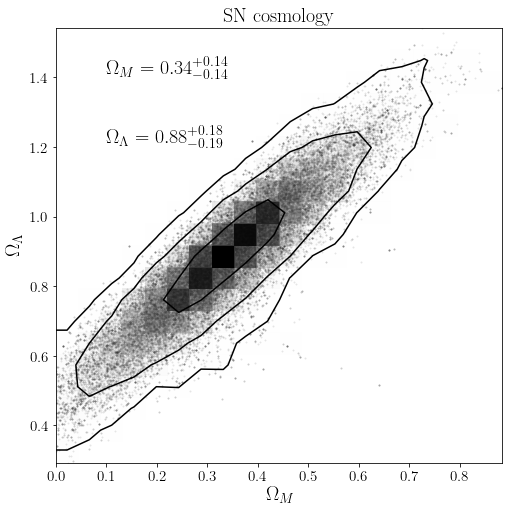

In [174]:
#------------------------------------------------------------
# 2d Histogram of two parameters. Contours correspond to 1sigma, 2sigma and 3sigma.

fig, ax = plt.subplots(figsize=(8,8))
corner.hist2d(samples.T[0], samples.T[1], ax=ax, 
              levels = 1.0 - np.exp(-0.5 * np.array([1, 2, 3]) ** 2), no_fill_contours=True)
ax.set_title('SN cosmology', fontsize=20)
ax.set_xlabel(r'$\Omega_M$', fontsize=20)
ax.set_ylabel(r'$\Omega_\Lambda$', fontsize=20)
ax.text(0.10, 1.4, r'$\Omega_M='+str(round(OmegaM_mcmc[0],2))
        +'^{+'+str(round(OmegaM_mcmc[1],2))
        +'}_{-'+str(round(OmegaM_mcmc[2],2))+'}$', fontsize=20)
ax.text(0.10, 1.2, r'$\Omega_\Lambda='+str('{:.2f}'.format(round(OmegaL_mcmc[0], 2)))
        +'^{+'+str(round(OmegaL_mcmc[1],2))
        +'}_{-'+str(round(OmegaL_mcmc[2],2))+'}$', fontsize=20)

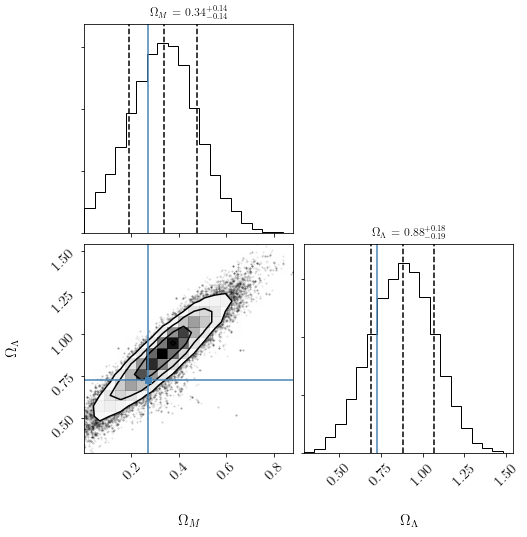

In [175]:
#------------------------------------------------------------
# Corner plot of MCMC parameter space. 
# Vertical lines correspond to 16%, 50% and 84%. 
# Blue lines are the concordance cosmology parameters.

import corner
fig, ax = plt.subplots(2,2, figsize=(8,8))
fig = corner.corner(samples[:,0:2], labels=["$\Omega_M$", "$\Omega_\Lambda$", "$\ln\,f$"],
                      truths=[0.27, 0.73, 0.9], use_math_text=True,
                   quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12}, fig = fig)